In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score

In [19]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Loading and Working on Train Data

In [3]:
train_set= pd.read_csv('train.csv')
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Dropping Unnecessary Columns

In [4]:
train_set.drop(labels= ['PassengerId','Name','Ticket','Cabin'], axis= 1, inplace = True)
train_set.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [5]:
train_set.shape

(891, 8)

## Null Value Handling

In [6]:
train_set.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [7]:
train_set['Embarked']= train_set['Embarked'].fillna(train_set['Embarked'].mode()[0])
train_set.dropna(axis= 0, how= 'any', inplace= True)

## X and y split

In [8]:
y_train= train_set.pop('Survived')
print(y_train.shape)
X_train= train_set
print(X_train.shape)

(714,)
(714, 7)


## Scaling Continuous Variables

In [10]:
scaler= MinMaxScaler()
X_train[['Age', 'Fare']]= scaler.fit_transform(X_train[['Age', 'Fare']])
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,0.271174,1,0,0.014151,S
1,1,female,0.472229,1,0,0.139136,C
2,3,female,0.321438,0,0,0.015469,S
3,1,female,0.434531,1,0,0.103644,S
4,3,male,0.434531,0,0,0.015713,S


## Creating Dummies

In [11]:
for i in X_train.columns:
    if i not in ['Age', 'Fare']:
        myd= pd.get_dummies(X_train[i], prefix= i, prefix_sep= '_', drop_first= True)
        X_train= pd.concat([X_train, myd], axis= 1)
        X_train.drop(labels= i, axis= 1, inplace= True)
    
X_train.head()

,Age,Fare,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S
0,0.271174,0.014151,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1
1,0.472229,0.139136,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0.321438,0.015469,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0.434531,0.103644,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,0.434531,0.015713,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [12]:
X_train.shape

(714, 18)

## Automated Feature Selection

In [14]:
logreg= LogisticRegression()
rfe= RFE(logreg, 10)
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=10)

In [15]:
rfe_table= pd.DataFrame()
rfe_table['Feature']= X_train.columns
rfe_table['Rank']= rfe.ranking_
rfe_table['Retain']= rfe.support_
rfe_table.sort_values(by= 'Rank', inplace= True)
rfe_table

,Feature,Rank,Retain
0,Age,1,True
14,Parch_5,1,True
13,Parch_4,1,True
9,SibSp_5,1,True
7,SibSp_3,1,True
8,SibSp_4,1,True
4,Sex_male,1,True
3,Pclass_3,1,True
2,Pclass_2,1,True
1,Fare,1,True


In [16]:
rfe_table= rfe_table[rfe_table['Retain']== True]
rfe_table

,Feature,Rank,Retain
0,Age,1,True
14,Parch_5,1,True
13,Parch_4,1,True
9,SibSp_5,1,True
7,SibSp_3,1,True
8,SibSp_4,1,True
4,Sex_male,1,True
3,Pclass_3,1,True
2,Pclass_2,1,True
1,Fare,1,True


In [17]:
col= rfe_table['Feature']
col

0          Age
14     Parch_5
13     Parch_4
9      SibSp_5
7      SibSp_3
8      SibSp_4
4     Sex_male
3     Pclass_3
2     Pclass_2
1         Fare
Name: Feature, dtype: object

In [18]:
X_train= X_train[col]
X_train.head()

,Age,Parch_5,Parch_4,SibSp_5,SibSp_3,SibSp_4,Sex_male,Pclass_3,Pclass_2,Fare
0,0.271174,0,0,0,0,0,1,1,0,0.014151
1,0.472229,0,0,0,0,0,0,0,0,0.139136
2,0.321438,0,0,0,0,0,0,1,0,0.015469
3,0.434531,0,0,0,0,0,0,0,0,0.103644
4,0.434531,0,0,0,0,0,1,1,0,0.015713


## Model Building

In [20]:
X_train_sm= sm.add_constant(X_train)
X_train_sm.head()

,const,Age,Parch_5,Parch_4,SibSp_5,SibSp_3,SibSp_4,Sex_male,Pclass_3,Pclass_2,Fare
0,1.0,0.271174,0,0,0,0,0,1,1,0,0.014151
1,1.0,0.472229,0,0,0,0,0,0,0,0,0.139136
2,1.0,0.321438,0,0,0,0,0,0,1,0,0.015469
3,1.0,0.434531,0,0,0,0,0,0,0,0,0.103644
4,1.0,0.434531,0,0,0,0,0,1,1,0,0.015713


In [21]:
logmodel= sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())
res= logmodel.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                            GLM   Df Residuals:                      703
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -313.53
Date:                Sun, 12 Dec 2021   Deviance:                       627.06
Time:                        12:20:52   Pearson chi2:                     763.
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8996      0.493      7.914      0.000       2.934       4.865
Age           -3.3402      0.667     -5.009      0.000      -4.647      -2.033
Parch_5       -1.1160      1.170     -0.954      0.340      -3.410       1.178
Parch_4      -21.9381   2.12e+04     -0.001      0.999   -4.15e+04    4.15e+04
SibSp_5      -22.0732   1.93e+04     -0.001      0.999   -3.79e+04    3.79e+04
SibSp_3       -1.9742      0.765     -2.582      0.010      -3.473      -0.476
SibSp_4       -1.6903      0.741     -2.282      0.022      -3.142      -0.239
Sex_male      -2.6155      0.216    -12.108      0.000      -3.039      -2.192
Pclass_3      -2.3576      0.340     -6.932      0.000      -3.024      -1.691
Pclass_2      -1.2829      0.322     -3.982      0.000      -1.914      -0.651
Fare           1.1471      1.292      0.888      0.375      -1.385       3.679
==============================================================================
"""

In [22]:
vif_table= pd.DataFrame()
vif_table['Feature']= X_train_sm.columns
vif_table['VIF Value']= [variance_inflation_factor(X_train_sm.values, i) for i in range(len(X_train_sm.columns))]
vif_table

,Feature,VIF Value
0,const,19.972962
1,Age,1.337449
2,Parch_5,1.029714
3,Parch_4,1.024793
4,SibSp_5,1.024761
5,SibSp_3,1.053588
6,SibSp_4,1.088990
7,Sex_male,1.086721
8,Pclass_3,2.776693
9,Pclass_2,2.073397


In [23]:
# Dropping Parch_4

X_train_sm1= X_train_sm.drop(labels= 'Parch_4', axis=1)


In [24]:
logmodel= sm.GLM(y_train, X_train_sm1, family= sm.families.Binomial())
res= logmodel.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                            GLM   Df Residuals:                      704
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -315.40
Date:                Sun, 12 Dec 2021   Deviance:                       630.79
Time:                        12:21:13   Pearson chi2:                     771.
No. Iterations:                    20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9694      0.487      8.159      0.000       3.016       4.923
Age           -3.4575      0.662     -5.221      0.000      -4.755      -2.159
Parch_5       -1.0488      1.169     -0.897      0.370      -3.341       1.243
SibSp_5      -21.0444   1.17e+04     -0.002      0.999    -2.3e+04     2.3e+04
SibSp_3       -1.9431      0.761     -2.553      0.011      -3.435      -0.452
SibSp_4       -1.6755      0.740     -2.265      0.024      -3.125      -0.226
Sex_male      -2.5999      0.215    -12.098      0.000      -3.021      -2.179
Pclass_3      -2.4230      0.336     -7.201      0.000      -3.082      -1.764
Pclass_2      -1.3103      0.320     -4.092      0.000      -1.938      -0.683
Fare           0.9141      1.228      0.745      0.457      -1.492       3.320
==============================================================================
"""

In [25]:
vif_table= pd.DataFrame()
vif_table['Feature']= X_train_sm1.columns
vif_table['VIF Value']= [variance_inflation_factor(X_train_sm1.values, i) for i in range(len(X_train_sm1.columns))]
vif_table

,Feature,VIF Value
0,const,19.778950
1,Age,1.322603
2,Parch_5,1.028951
3,SibSp_5,1.024712
4,SibSp_3,1.053279
5,SibSp_4,1.088972
6,Sex_male,1.085557
7,Pclass_3,2.741960
8,Pclass_2,2.067661
9,Fare,1.672858


In [26]:
# Dropping SibSp_5
X_train_sm2= X_train_sm1.drop(labels= 'SibSp_5', axis= 1)
X_train_sm2.head()

,const,Age,Parch_5,SibSp_3,SibSp_4,Sex_male,Pclass_3,Pclass_2,Fare
0,1.0,0.271174,0,0,0,1,1,0,0.014151
1,1.0,0.472229,0,0,0,0,0,0,0.139136
2,1.0,0.321438,0,0,0,0,1,0,0.015469
3,1.0,0.434531,0,0,0,0,0,0,0.103644
4,1.0,0.434531,0,0,0,1,1,0,0.015713


In [27]:
logmodel= sm.GLM(y_train, X_train_sm2, family= sm.families.Binomial())
res= logmodel.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                            GLM   Df Residuals:                      705
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -317.58
Date:                Sun, 12 Dec 2021   Deviance:                       635.16
Time:                        12:21:34   Pearson chi2:                     776.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9418      0.484      8.149      0.000       2.994       4.890
Age           -3.3635      0.656     -5.125      0.000      -4.650      -2.077
Parch_5       -1.0228      1.169     -0.875      0.382      -3.314       1.269
SibSp_3       -1.8869      0.759     -2.487      0.013      -3.374      -0.400
SibSp_4       -1.6129      0.738     -2.184      0.029      -3.060      -0.166
Sex_male      -2.5994      0.214    -12.145      0.000      -3.019      -2.180
Pclass_3      -2.4584      0.335     -7.331      0.000      -3.116      -1.801
Pclass_2      -1.3114      0.319     -4.108      0.000      -1.937      -0.686
Fare           0.7746      1.208      0.641      0.521      -1.592       3.142
==============================================================================
"""

In [28]:
vif_table= pd.DataFrame()
vif_table['Feature']= X_train_sm2.columns
vif_table['VIF Value']= [variance_inflation_factor(X_train_sm2.values, i) for i in range(len(X_train_sm2.columns))]
vif_table

,Feature,VIF Value
0,const,19.763122
1,Age,1.309280
2,Parch_5,1.028911
3,SibSp_3,1.051739
4,SibSp_4,1.085666
5,Sex_male,1.084136
6,Pclass_3,2.732758
7,Pclass_2,2.067474
8,Fare,1.666045


In [29]:
# Dropping Parch_5
X_train_sm3= X_train_sm2.drop(labels= 'Parch_5', axis= 1)
X_train_sm3.head()

,const,Age,SibSp_3,SibSp_4,Sex_male,Pclass_3,Pclass_2,Fare
0,1.0,0.271174,0,0,1,1,0,0.014151
1,1.0,0.472229,0,0,0,0,0,0.139136
2,1.0,0.321438,0,0,0,1,0,0.015469
3,1.0,0.434531,0,0,0,0,0,0.103644
4,1.0,0.434531,0,0,1,1,0,0.015713


In [30]:
logmodel= sm.GLM(y_train, X_train_sm3, family= sm.families.Binomial())
res= logmodel.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                            GLM   Df Residuals:                      706
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -318.02
Date:                Sun, 12 Dec 2021   Deviance:                       636.03
Time:                        12:21:54   Pearson chi2:                     781.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9744      0.483      8.231      0.000       3.028       4.921
Age           -3.4374      0.653     -5.264      0.000      -4.717      -2.158
SibSp_3       -1.8721      0.758     -2.469      0.014      -3.358      -0.386
SibSp_4       -1.5997      0.737     -2.169      0.030      -3.045      -0.154
Sex_male      -2.5821      0.213    -12.127      0.000      -2.999      -2.165
Pclass_3      -2.4992      0.333     -7.507      0.000      -3.152      -1.847
Pclass_2      -1.3253      0.319     -4.159      0.000      -1.950      -0.701
Fare           0.7121      1.200      0.593      0.553      -1.640       3.064
==============================================================================
"""

In [31]:
vif_table= pd.DataFrame()
vif_table['Feature']= X_train_sm3.columns
vif_table['VIF Value']= [variance_inflation_factor(X_train_sm3.values, i) for i in range(len(X_train_sm3.columns))]
vif_table

,Feature,VIF Value
0,const,19.685838
1,Age,1.295516
2,SibSp_3,1.051483
3,SibSp_4,1.085574
4,Sex_male,1.072859
5,Pclass_3,2.693072
6,Pclass_2,2.063675
7,Fare,1.662841


In [32]:
# Dropping Fare

X_train_sm4= X_train_sm3.drop(labels= 'Fare', axis= 1)


In [33]:
logmodel= sm.GLM(y_train, X_train_sm4, family= sm.families.Binomial())
res= logmodel.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                            GLM   Df Residuals:                      707
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -318.20
Date:                Sun, 12 Dec 2021   Deviance:                       636.40
Time:                        12:22:12   Pearson chi2:                     777.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1129      0.425      9.678      0.000       3.280       4.946
Age           -3.4810      0.649     -5.364      0.000      -4.753      -2.209
SibSp_3       -1.8057      0.741     -2.436      0.015      -3.259      -0.353
SibSp_4       -1.5866      0.738     -2.150      0.032      -3.033      -0.140
Sex_male      -2.5928      0.212    -12.219      0.000      -3.009      -2.177
Pclass_3      -2.6026      0.285     -9.130      0.000      -3.161      -2.044
Pclass_2      -1.4120      0.284     -4.968      0.000      -1.969      -0.855
==============================================================================
"""

In [34]:
vif_table= pd.DataFrame()
vif_table['Feature']= X_train_sm4.columns
vif_table['VIF Value']= [variance_inflation_factor(X_train_sm4.values, i) for i in range(len(X_train_sm4.columns))]
vif_table

,Feature,VIF Value
0,const,12.977376
1,Age,1.279021
2,SibSp_3,1.032848
3,SibSp_4,1.082999
4,Sex_male,1.060027
5,Pclass_3,1.770089
6,Pclass_2,1.547114


<b>Final Model now saved in res</b>

## Applying Model to predict the survival probablity on Train Set

In [35]:
y_train_pred= res.predict(X_train_sm4)
y_train_pred.head()

0    0.116444
1    0.921943
2    0.596598
3    0.930879
4    0.069449
dtype: float64

In [36]:
y_train_pred.isna().sum()

0

### Assuming Threshold of 0.5

In [37]:
y_train_pred_df= pd.DataFrame()
y_train_pred_df['Survival']= y_train.values
y_train_pred_df['Sur_Prob']= y_train_pred.values
y_train_pred_df['Pred_0.5']= y_train_pred_df['Sur_Prob'].apply(lambda x: 1 if x>0.5 else 0)
y_train_pred_df

,Survival,Sur_Prob,Pred_0.5
0,0,0.116444,0
1,1,0.921943,1
2,1,0.596598,1
3,1,0.930879,1
4,0,0.069449,0
...,...,...,...
709,0,0.455782,0
710,0,0.258344,0
711,1,0.964433,1
712,1,0.598957,1


### Measuring Accuracy Parameters

In [39]:
accuracy_score(y_true= y_train_pred_df['Survival'], y_pred= y_train_pred_df['Pred_0.5'])

0.8109243697478992

In [40]:
confusion1= confusion_matrix(y_true= y_train_pred_df['Survival'], y_pred= y_train_pred_df['Pred_0.5'])
confusion1

array([[365,  59],
       [ 76, 214]], dtype=int64)

In [41]:
# Predicted          Not Survived     Survived
# Actual
# Not Survived            296           128
# Survived                205            85

In [42]:
TP1= confusion1[1,1]
FP1= confusion1[0,1]
TN1= confusion1[0,0]
FN1= confusion1[1,0]

In [43]:
acc_measures= pd.DataFrame()
acc_measures['Measures']= ['Sensitivity', 'Specificity', 'TPR', 'FPR', 'Precision', 'Recall']
acc_measures['Measure at 0.5']= [round((TP1/(TP1+FN1)*100), 2), round((TN1/(FP1+TN1)*100), 2),
                                round((TP1/(TP1+FN1)*100), 2), round((FP1/(TN1+FP1)*100), 2),
                                round((TP1/(TP1+FP1)*100), 2), round((TP1/(TP1+FN1)*100), 2)]
acc_measures

,Measures,Measure at 0.5
0,Sensitivity,73.79
1,Specificity,86.08
2,TPR,73.79
3,FPR,13.92
4,Precision,78.39
5,Recall,73.79


## ROC Curve

In [44]:
fpr, tpr, thresholds= roc_curve(y_true= y_train_pred_df['Survival'], y_score= y_train_pred_df['Sur_Prob'])
auc_score= roc_auc_score(y_true= y_train_pred_df['Survival'], y_score= y_train_pred_df['Sur_Prob'])

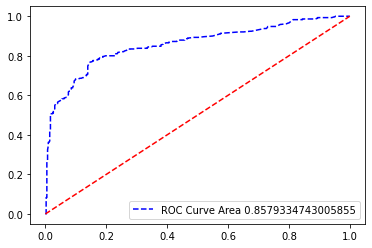

In [45]:
plt.figure()
plt.plot(fpr, tpr, 'b--', label= (f'ROC Curve Area {auc_score}'))
plt.plot([0,1], [0,1], 'r--')
plt.legend()
plt.show()

## Finding Optimal Threshold            

In [46]:
numbers= [x/10 for x in range(11)]
numbers

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [47]:
y_train_pred_df.head()

,Survival,Sur_Prob,Pred_0.5
0,0,0.116444,0
1,1,0.921943,1
2,1,0.596598,1
3,1,0.930879,1
4,0,0.069449,0


In [48]:
for i in numbers:
    y_train_pred_df[f'Pred_{i}']= y_train_pred_df['Sur_Prob'].apply(lambda x: 1 if x>=i else 0)
y_train_pred_df.head()

,Survival,Sur_Prob,Pred_0.5,Pred_0.0,Pred_0.1,Pred_0.2,Pred_0.3,Pred_0.4,Pred_0.6,Pred_0.7,Pred_0.8,Pred_0.9,Pred_1.0
0,0,0.116444,0,1,1,0,0,0,0,0,0,0,0
1,1,0.921943,1,1,1,1,1,1,1,1,1,1,0
2,1,0.596598,1,1,1,1,1,1,0,0,0,0,0
3,1,0.930879,1,1,1,1,1,1,1,1,1,1,0
4,0,0.069449,0,1,0,0,0,0,0,0,0,0,0


### Building Quality Measure DF

In [49]:
cutoff_df= pd.DataFrame(columns= ['Probability', 'Accuracy', 'Specificity', 'Sensitivity', 'TPR', 'FPR', 'Precision', 'Recall'])

for i in numbers:
    cm= confusion_matrix(y_true= y_train_pred_df['Survival'], y_pred= y_train_pred_df[f'Pred_{i}'])
    
    accuracy= (cm[0,0]+cm[1,1])/ sum(sum(cm))
    specificity= cm[0,0]/(cm[0,0]+cm[0,1])
    sensitivity= cm[1,1]/(cm[1,1]+cm[1,0])
    tpr= cm[1,1]/(cm[1,1]+cm[1,0])
    fpr= cm[1,0]/(cm[1,0]+cm[0,0])
    precision= cm[1,1]/(cm[1,1]+cm[0,1])
    recall= cm[1,1]/(cm[1,1]+cm[1,0])
    
    cutoff_df.loc[i]= [i, accuracy, specificity, sensitivity, tpr, fpr, precision, recall]
    
cutoff_df

,Probability,Accuracy,Specificity,Sensitivity,TPR,FPR,Precision,Recall
0.0,0.0,0.406162,0.000000,1.000000,1.000000,NaN,0.406162,1.000000
0.1,0.1,0.557423,0.301887,0.931034,0.931034,0.135135,0.477032,0.931034
0.2,0.2,0.700280,0.582547,0.872414,0.872414,0.130282,0.588372,0.872414
0.3,0.3,0.766106,0.719340,0.834483,0.834483,0.135977,0.670360,0.834483
0.4,0.4,0.805322,0.811321,0.796552,0.796552,0.146402,0.742765,0.796552
0.5,0.5,0.810924,0.860849,0.737931,0.737931,0.172336,0.783883,0.737931
0.6,0.6,0.799720,0.910377,0.637931,0.637931,0.213849,0.829596,0.637931
0.7,0.7,0.798319,0.969340,0.548276,0.548276,0.241697,0.924419,0.548276
0.8,0.8,0.759104,0.983491,0.431034,0.431034,0.283505,0.946970,0.431034
0.9,0.9,0.686275,0.995283,0.234483,0.234483,0.344720,0.971429,0.234483


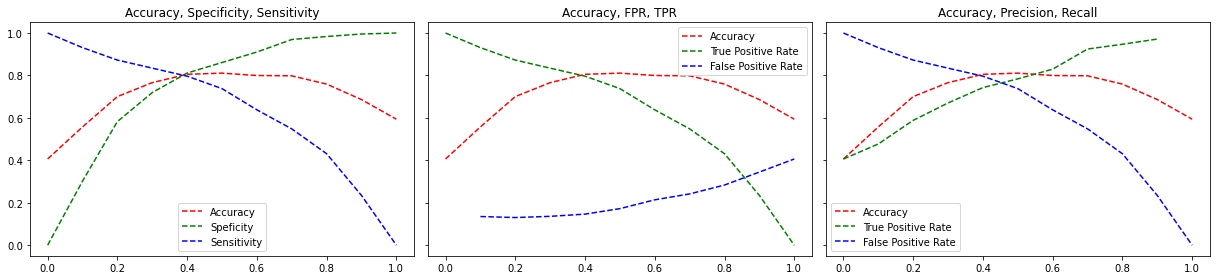

In [50]:
fig, ax= plt.subplots(nrows= 1, ncols= 3, figsize= (17, 4), sharey= True)

ax[0].plot(cutoff_df['Accuracy'], 'r--', label= 'Accuracy')
ax[0].plot(cutoff_df['Specificity'], 'g--', label= 'Speficity')
ax[0].plot(cutoff_df['Sensitivity'], 'b--', label= 'Sensitivity')
ax[0].set_title('Accuracy, Specificity, Sensitivity')
ax[0].legend()

ax[1].plot(cutoff_df['Accuracy'], 'r--', label= 'Accuracy')
ax[1].plot(cutoff_df['TPR'], 'g--', label= 'True Positive Rate')
ax[1].plot(cutoff_df['FPR'], 'b--', label= 'False Positive Rate')
ax[1].set_title('Accuracy, FPR, TPR')
ax[1].legend()

ax[2].plot(cutoff_df['Accuracy'], 'r--', label= 'Accuracy')
ax[2].plot(cutoff_df['Precision'], 'g--', label= 'True Positive Rate')
ax[2].plot(cutoff_df['Recall'], 'b--', label= 'False Positive Rate')
ax[2].set_title('Accuracy, Precision, Recall')
ax[2].legend()

plt.tight_layout()
plt.show()


<b>Accuracy is the main criteria in this case. Hence, focussing more on accuracy then other parameters</b>

In [51]:
test_numbers= [x/100 for x in range(35,56)]
print(test_numbers)


[0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55]


In [52]:
y_train_pred_df1= pd.DataFrame()
y_train_pred_df1['Survival']= y_train_pred_df['Survival']
y_train_pred_df1['Sur_Prob']= y_train_pred_df['Sur_Prob']

for i in test_numbers:
    y_train_pred_df1[i]= y_train_pred_df1['Sur_Prob'].apply(lambda x: 1 if x>=i else 0)
y_train_pred_df1.head()


,Survival,Sur_Prob,0.35,0.36,0.37,0.38,0.39,0.4,0.41,0.42,...,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55
0,0,0.116444,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.921943,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,0.596598,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,0.930879,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,0,0.069449,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
cutoff_df1= pd.DataFrame(columns= ['Probability', 'Accuracy', 'Specificity', 'Sensitivity', 'TPR', 'FPR', 'Precision', 'Recall'])

for i in test_numbers:
    cm1= confusion_matrix(y_true= y_train_pred_df1['Survival'], y_pred= y_train_pred_df1[i])
    
    accuracy= (cm1[0,0]+cm1[1,1])/ sum(sum(cm1))
    specificity= cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensitivity= cm1[1,1]/(cm1[1,1]+cm1[1,0])
    tpr= cm1[1,1]/(cm1[1,1]+cm1[1,0])
    fpr= cm1[1,0]/(cm1[1,0]+cm1[0,0])
    precision= cm1[1,1]/(cm1[1,1]+cm1[0,1])
    recall= cm1[1,1]/(cm1[1,1]+cm1[1,0])
    
    cutoff_df1.loc[i]= [i, accuracy, specificity, sensitivity, tpr, fpr, precision, recall]
    
cutoff_df1

,Probability,Accuracy,Specificity,Sensitivity,TPR,FPR,Precision,Recall
0.35,0.35,0.784314,0.761792,0.817241,0.817241,0.140957,0.701183,0.817241
0.36,0.36,0.782913,0.764151,0.810345,0.810345,0.145119,0.701493,0.810345
0.37,0.37,0.784314,0.773585,0.800000,0.800000,0.150259,0.707317,0.800000
0.38,0.38,0.791317,0.785377,0.800000,0.800000,0.148338,0.718266,0.800000
0.39,0.39,0.796919,0.794811,0.800000,0.800000,0.146835,0.727273,0.800000
0.40,0.40,0.805322,0.811321,0.796552,0.796552,0.146402,0.742765,0.796552
0.41,0.41,0.806723,0.816038,0.793103,0.793103,0.147783,0.746753,0.793103
0.42,0.42,0.808123,0.818396,0.793103,0.793103,0.147420,0.749186,0.793103
0.43,0.43,0.808123,0.823113,0.786207,0.786207,0.150852,0.752475,0.786207
0.44,0.44,0.809524,0.827830,0.782759,0.782759,0.152174,0.756667,0.782759


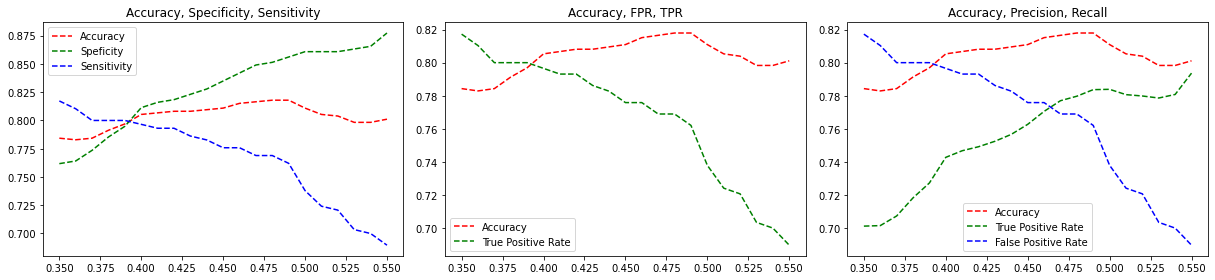

In [54]:
fig, ax= plt.subplots(nrows= 1, ncols= 3, figsize= (17, 4))

ax[0].plot(cutoff_df1['Accuracy'], 'r--', label= 'Accuracy')
ax[0].plot(cutoff_df1['Specificity'], 'g--', label= 'Speficity')
ax[0].plot(cutoff_df1['Sensitivity'], 'b--', label= 'Sensitivity')
ax[0].set_title('Accuracy, Specificity, Sensitivity')
ax[0].legend()

ax[1].plot(cutoff_df1['Accuracy'], 'r--', label= 'Accuracy')
ax[1].plot(cutoff_df1['TPR'], 'g--', label= 'True Positive Rate')
# ax[1].plot(cutoff_df1['FPR'], 'b--', label= 'False Positive Rate')
ax[1].set_title('Accuracy, FPR, TPR')
ax[1].legend()

ax[2].plot(cutoff_df1['Accuracy'], 'r--', label= 'Accuracy')
ax[2].plot(cutoff_df1['Precision'], 'g--', label= 'True Positive Rate')
ax[2].plot(cutoff_df1['Recall'], 'b--', label= 'False Positive Rate')
ax[2].set_title('Accuracy, Precision, Recall')
ax[2].legend()

plt.tight_layout()
plt.show()

<b>Applying 0.48 as threshold for better results on 'Accuracy' measure</b>

In [55]:
y_train_pred_df2= y_train_pred_df1[['Survival','Sur_Prob']]
y_train_pred_df2['T 0.392']= y_train_pred_df2['Sur_Prob'].apply(lambda x: 1 if x> 0.48 else 0)
y_train_pred_df2.head()

,Survival,Sur_Prob,T 0.392
0,0,0.116444,0
1,1,0.921943,1
2,1,0.596598,1
3,1,0.930879,1
4,0,0.069449,0


In [56]:
confusion2= confusion_matrix(y_true= y_train_pred_df2['Survival'], y_pred= y_train_pred_df2['T 0.392'])
confusion2

array([[361,  63],
       [ 67, 223]], dtype=int64)

In [57]:
TP2= confusion2[1,1]
TN2= confusion2[0,0]
FN2= confusion2[1,0]
FP2= confusion2[0,1]

In [58]:
acc_measures['Measure at 0.392']= [round((TP2/(TP2+FN2))*100, 2), round((TN2/(TN2+FP2))*100, 2),
                                  round((TP2/(TP2+FN2))*100, 2), round((FP2/(TN2+FP2))*100, 2),
                                  round((TP2/(TP2+FP2))*100, 2), round((TP2/(TP2+FN2))*100, 2)]

acc_measures

,Measures,Measure at 0.5,Measure at 0.392
0,Sensitivity,73.79,76.90
1,Specificity,86.08,85.14
2,TPR,73.79,76.90
3,FPR,13.92,14.86
4,Precision,78.39,77.97
5,Recall,73.79,76.90


# Loading and Working on Test Set

In [59]:
test_data= pd.read_csv('test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [60]:
test_data.shape

(418, 11)

## Dropping unnecessary columns

In [61]:
test_dataml= test_data.drop(labels= ['PassengerId','Name','Ticket','Cabin'], axis= 1)
test_dataml.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


## Null Value Handling

In [62]:
test_dataml.isna().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

In [63]:
test_dataml['Fare']= test_dataml['Fare'].fillna(test_dataml['Fare'].median())
test_dataml['Age']= test_dataml['Age'].fillna(test_dataml['Age'].median())

In [64]:
test_dataml.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


## Scaling continuous variables using our fitted scaler

In [65]:
test_dataml[['Age', 'Fare']]= scaler.transform(test_dataml[['Age', 'Fare']])
test_dataml.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,0.428248,0,0,0.015282,Q
1,3,female,0.585323,1,0,0.013663,S
2,2,male,0.773813,0,0,0.018909,Q
3,3,male,0.334004,0,0,0.016908,S
4,3,female,0.271174,1,1,0.023984,S


## Dummy Creation

In [66]:
for i in test_dataml.columns:
    if i not in ['Age', 'Fare']:
        myd= pd.get_dummies(test_dataml[i], prefix= i, prefix_sep= '_', drop_first= True)
        test_dataml= pd.concat([test_dataml, myd], axis= 1)
        test_dataml.drop(labels= i, axis= 1, inplace= True)
    
test_dataml.head()

,Age,Fare,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Embarked_Q,Embarked_S
0,0.428248,0.015282,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.585323,0.013663,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.773813,0.018909,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.334004,0.016908,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0.271174,0.023984,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1


## Adding Constant

In [67]:
test_dataml= sm.add_constant(test_dataml)

## Managing Columns based on final train model

In [68]:
for i in test_dataml.columns:
    if i not in X_train_sm4.columns:
        test_dataml.drop(labels= i, axis= 1, inplace= True)
test_dataml.head()

,const,Age,Pclass_2,Pclass_3,Sex_male,SibSp_3,SibSp_4
0,1.0,0.428248,0,1,1,0,0
1,1.0,0.585323,0,1,0,0,0
2,1.0,0.773813,1,0,1,0,0
3,1.0,0.334004,0,1,1,0,0
4,1.0,0.271174,0,1,0,0,0


## Making Probability Predictions

In [69]:
original_test_data= pd.read_csv('test.csv')
original_test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [70]:
y_test_pred= pd.DataFrame()
y_test_pred['PassengerId']= original_test_data['PassengerId']
y_test_pred['Sur_Prob']= res.predict(test_dataml)
y_test_pred['Prediction']= y_test_pred['Sur_Prob'].apply(lambda x: 1 if x>= 0.48 else 0)
y_test_pred.head()

,PassengerId,Sur_Prob,Prediction
0,892,0.174043,0
1,893,0.619825,1
2,894,0.048368,0
3,895,0.226325,0
4,896,0.829537,1


# Checking Final Predictions

In [71]:
y_test_pred_final= y_test_pred.copy(deep= True)
y_test_pred_final.head()

,PassengerId,Sur_Prob,Prediction
0,892,0.174043,0
1,893,0.619825,1
2,894,0.048368,0
3,895,0.226325,0
4,896,0.829537,1


In [72]:
y_test_pred_final.shape

(418, 3)

In [73]:
answers= pd.read_csv('gender_submission.csv')
answers.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [74]:
answers.shape

(418, 2)

In [75]:
y_test_pred_final= y_test_pred_final.merge(answers, on= 'PassengerId', how= 'inner')
y_test_pred_final.head()

,PassengerId,Sur_Prob,Prediction,Survived
0,892,0.174043,0,0
1,893,0.619825,1,1
2,894,0.048368,0,0
3,895,0.226325,0,0
4,896,0.829537,1,1


In [76]:
accuracy_score(y_true= y_test_pred_final['Survived'], y_pred= y_test_pred_final['Prediction'])

0.930622009569378

In [77]:
auc_score= roc_auc_score(y_true= y_test_pred_final['Survived'], y_score= y_test_pred_final['Sur_Prob'])

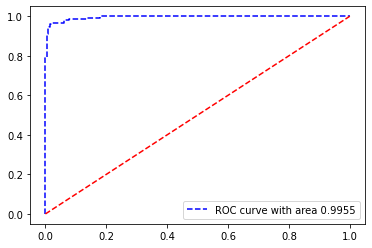

In [78]:
fpr, tpr, thresholds= roc_curve(y_true= y_test_pred_final['Survived'], y_score= y_test_pred_final['Sur_Prob'])
plt.plot(fpr, tpr, 'b--', label= (f'ROC curve with area {round(auc_score, 4)}'))
plt.plot([0,1], [0,1], 'r--')
plt.legend()
plt.show()

In [79]:
confusion3= confusion_matrix(y_true= y_test_pred_final['Survived'], y_pred= y_test_pred_final['Prediction'])
confusion3

array([[239,  27],
       [  2, 150]], dtype=int64)

In [80]:
TP3= confusion3[1,1]
TN3= confusion3[0,0]
FN3= confusion3[1,0]
FP3= confusion3[0,1]

In [81]:
acc_measures['Test Measures']= [round((TP3/(TP3+FN3))*100, 2), round((TN3/(TN3+FP3))*100, 2),
                                  round((TP3/(TP3+FN3))*100, 2), round((FP3/(TN3+FP3))*100, 2),
                                  round((TP3/(TP3+FP3))*100, 2), round((TP3/(TP3+FN3))*100, 2)]

acc_measures

,Measures,Measure at 0.5,Measure at 0.392,Test Measures
0,Sensitivity,73.79,76.90,98.68
1,Specificity,86.08,85.14,89.85
2,TPR,73.79,76.90,98.68
3,FPR,13.92,14.86,10.15
4,Precision,78.39,77.97,84.75
5,Recall,73.79,76.90,98.68


In [82]:
accuracy_score(y_true= y_test_pred_final['Survived'], y_pred= y_test_pred_final['Prediction'])

0.930622009569378

# Creating Submission File

In [85]:
submission= y_test_pred.copy(deep= True)
submission.head()

,PassengerId,Sur_Prob,Prediction
0,892,0.174043,0
1,893,0.619825,1
2,894,0.048368,0
3,895,0.226325,0
4,896,0.829537,1


In [86]:
submission.drop(labels= 'Sur_Prob', axis= 1, inplace= True)

In [87]:
submission.head()

,PassengerId,Prediction
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [88]:
submission.columns= ['PassengerId','Survived']
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [90]:
submission.sort_values(by= 'PassengerId', inplace= True)

In [91]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [92]:
submission.to_csv('submission_file.csv')